In [10]:
!pip install gymnasium stable-baselines3[extra]

In [35]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class GoldPriceEnv(gym.Env):
    def __init__(self, data, initial_observed, unobserved):
        super(GoldPriceEnv, self).__init__()
        self.data = data
        self.initial_observed = initial_observed
        self.unobserved = unobserved
        self.current_step = 0
        self.action_space = spaces.Discrete(len(data.columns))  # Actions are to select features
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32) # Define observation space with float32 dtype
        self.selected_features = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.selected_features = []
        return self._next_observation(), {}

    def _next_observation(self):
        obs = np.zeros(len(self.data.columns), dtype=np.float32) # Create obs array with float32 dtype
        for i, col in enumerate(self.data.columns):
            if col in self.selected_features:
                obs[i] = 1
        return obs

    def step(self, action):
        done = False
        reward = 0
        # Extract the integer action from the array
        action = action.item() # Extract the integer value from the action array
        if self.data.columns[action] not in self.selected_features:
            self.selected_features.append(self.data.columns[action])
            reward = 1  # Simple reward for selecting a new feature
        else:
            reward = -1  # Penalty for selecting an already selected feature


        self.current_step += 1
        if self.current_step >= len(self.data.columns):
            done = True

        # Return the observation, reward, terminated, truncated, and info dictionary
        return self._next_observation(), reward, done, False, {} # Added truncated and empty info dict


    def render(self, mode='human', close=False):
        print(f"Step: {self.current_step}, Selected features: {self.selected_features}")

# Load the data from the provided Excel file
file_path = '/content/FINAL_USO.xls'
data = pd.read_csv(file_path)

# Preprocessing (assuming the dataset has a 'Date' column and 'Price' column)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature extraction (simple example)
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['DayOfWeek'] = data.index.dayofweek
data['DayOfYear'] = data.index.dayofyear

# Instantiate the environment
initial_observed = data.sample(frac=0.2, random_state=1)
unobserved = data.drop(initial_observed.index)
env = GoldPriceEnv(data, initial_observed, unobserved)


In [14]:
data.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open',
       'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'SP_volume', 'DJ_open',
       'DJ_high', 'DJ_low', 'DJ_close', 'DJ_Ajclose', 'DJ_volume', 'EG_open',
       'EG_high', 'EG_low', 'EG_close', 'EG_Ajclose', 'EG_volume', 'EU_Price',
       'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price', 'OF_Open',
       'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price', 'OS_Open',
       'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open', 'SF_High',
       'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open', 'USB_High',
       'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low',
       'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_High', 'USO

In [36]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Check the custom environment
check_env(env)

# Instantiate the DQN agent
model = DQN('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

# Test the trained agent
state, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(state)
    state, reward, done, _, info = env.step(action) # Unpack the 5 returned values
    env.render()

# Extract the selected features after training
selected_features = env.selected_features




Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1138     |
|    time_elapsed     | 0        |
|    total_timesteps  | 340      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 59       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85       |
|    ep_rew_mean      | -1.75    |
|    exploration_rate | 0.354    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 982      |
|    time_elapsed     | 0        |
|    total_timesteps  | 680      |
| train/              |        

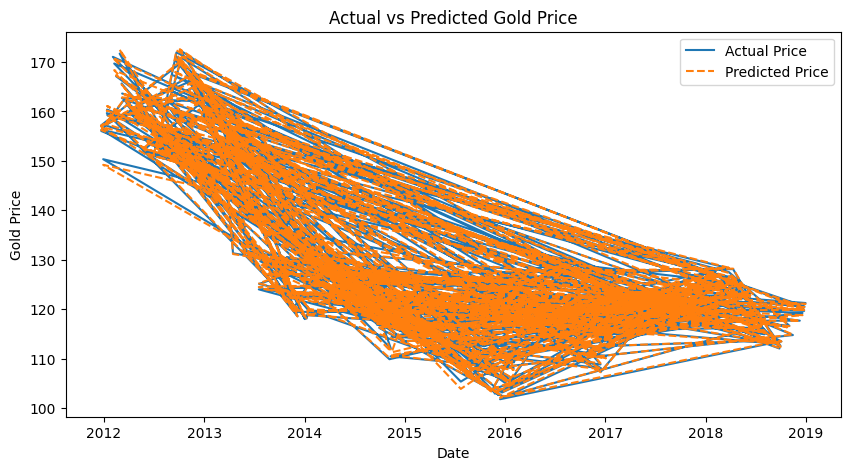

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Prepare the data for prediction
X = data[selected_features]
y = data['Close']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price')
plt.legend()
plt.show()


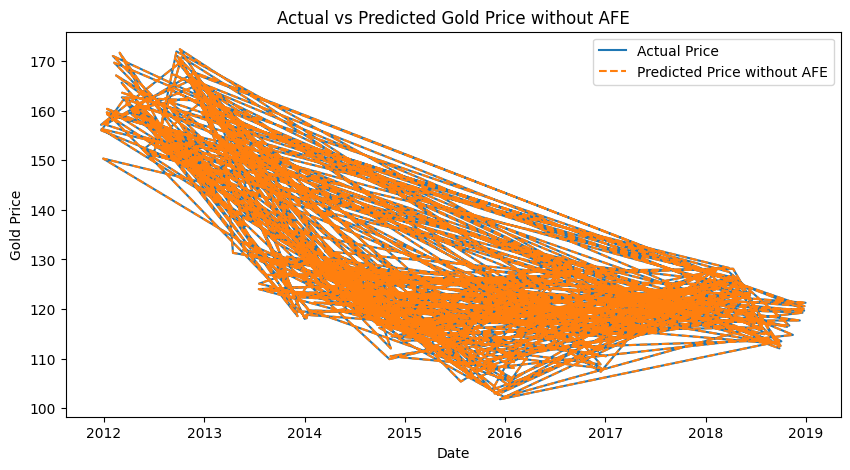

In [31]:
# Train and predict without AFE (using all features)
X_all = data.drop(columns=['Close'])
y_all = data['Close']

# Standardize the features
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# Split the data into training and testing sets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=0)

# Train a linear regression model
model_all = LinearRegression()
model_all.fit(X_all_train, y_all_train)

# Predict
predictions_all = model_all.predict(X_all_test)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_all_test.index, y_all_test, label='Actual Price')
plt.plot(y_all_test.index, predictions_all, label='Predicted Price without AFE', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price without AFE')
plt.legend()
plt.show()


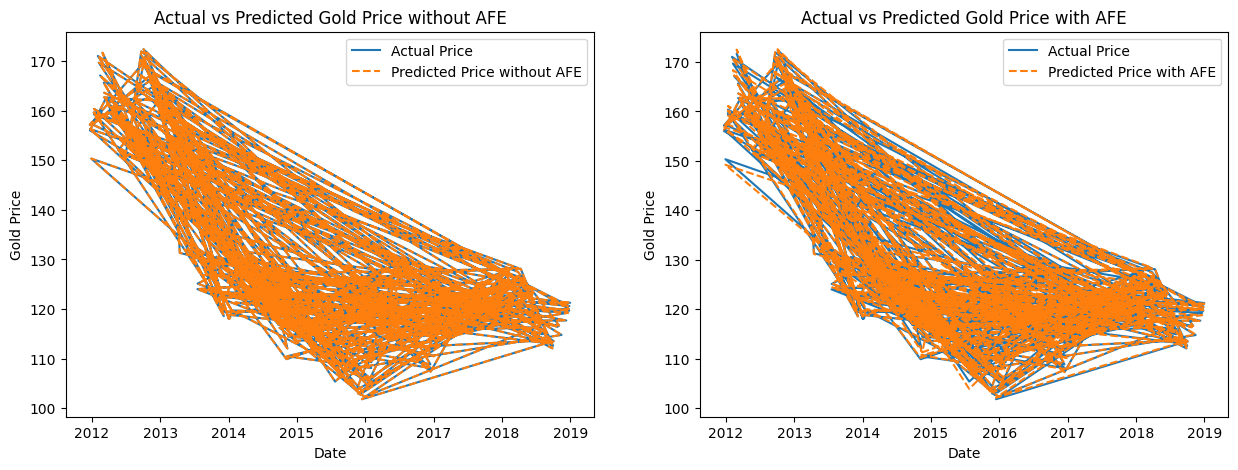

In [32]:
# Plot the comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_all_test.index, y_all_test, label='Actual Price')
plt.plot(y_all_test.index, predictions_all, label='Predicted Price without AFE', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price without AFE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price with AFE', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price with AFE')
plt.legend()

plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 50)            12400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32651 (127.54 KB)
Trainable params: 32651 (127.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
43/43 [==============================] - 10s 51ms/step - loss: 15514.0312 - val_loss: 12288.3633
Epoch 2/20
43/43 [==============================] - 1s 31ms/step - loss: 13968.7959 - val_loss: 11625.0264
Epoch 3/20
43/43 [==============================] - 1s 30ms/step 

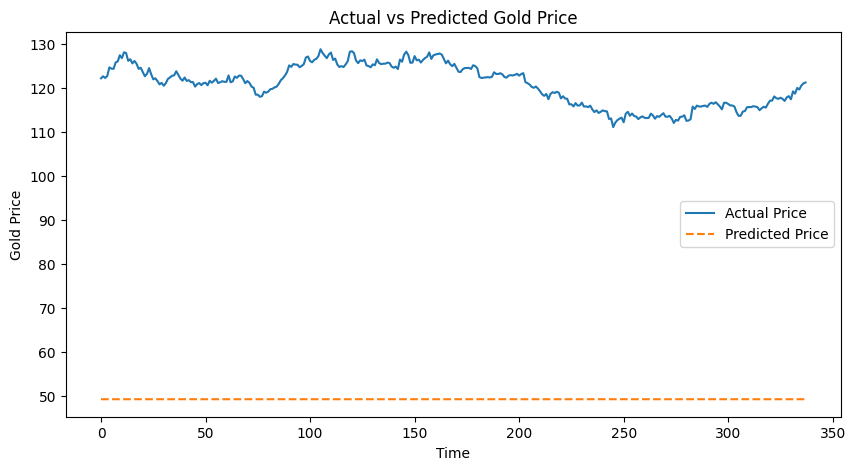

In [39]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM



# Prepare the data
X = data[selected_features]
y = data['Adj Close']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30  # Use last 30 days to predict the next day
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)

# Split the data into training and testing sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict the prices
y_pred = model.predict(X_test)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price')
plt.legend()
plt.show()


1/1 [==============================] - 0s 28ms/step


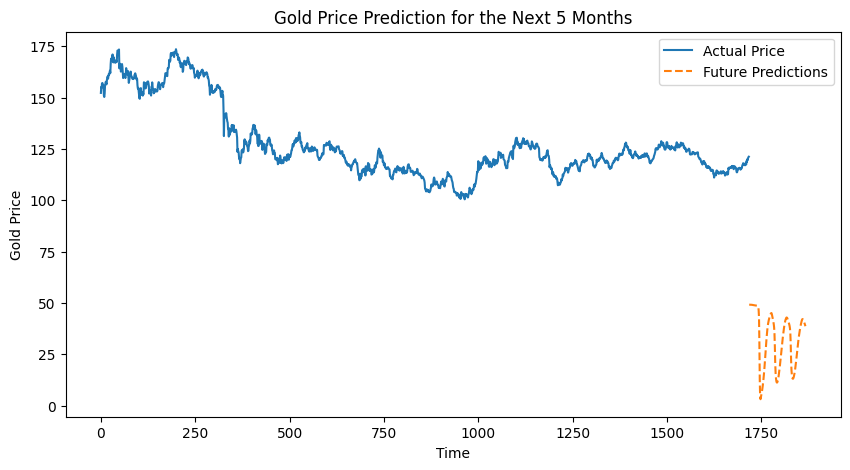

In [40]:
# Function to make predictions for the next n steps
def predict_future(model, X, n_steps):
    predictions = []
    current_input = X[-1]

    for _ in range(n_steps):
        pred = model.predict(current_input.reshape(1, time_steps, X.shape[2]))
        predictions.append(pred[0, 0])
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1] = np.append(pred[0], np.zeros(X.shape[2] - 1))

    return predictions

# Predict the next 5 months (150 days)
future_predictions = predict_future(model, X_seq, 150)

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(range(len(y)), y, label='Actual Price')
plt.plot(range(len(y), len(y) + 150), future_predictions, label='Future Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction for the Next 5 Months')
plt.legend()
plt.show()


In [1]:
import pandas as pd
import numpy as np

# Load the data from the provided Excel file
file_path = '/content/FINAL_USO.xls'
data = pd.read_csv(file_path)

# Preprocessing (assuming the dataset has a 'Date' column and 'Price' column)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature extraction (simple example)
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['DayOfWeek'] = data.index.dayofweek
data['DayOfYear'] = data.index.dayofyear
data['Quarter'] = data.index.quarter

# Calculate moving averages as additional features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Fill missing values
data.fillna(method='bfill', inplace=True)

# Display the first few rows of the data
data.head()


,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,USO_Volume,Day,Month,Year,DayOfWeek,DayOfYear,Quarter,MA_5,MA_10,MA_20
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,122.180000,...,12616700,15,12,2011,3,349,4,155.313999,154.519998,155.962499
2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,121.589996,...,12578800,16,12,2011,4,350,4,155.313999,154.519998,155.962499
2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,120.290001,...,7418200,19,12,2011,0,353,4,155.313999,154.519998,155.962499
2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,123.930000,...,10041600,20,12,2011,1,354,4,155.313999,154.519998,155.962499
2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,124.169998,...,10728000,21,12,2011,2,355,4,155.313999,154.519998,155.962499


from matplotlib import pyplot as plt
_df_0['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Low', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Close', y='Adj Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('High', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High']
  ys = series['Low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('High', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High')
_ = plt.ylabel('Low')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('High', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High']
  ys = series['Adj Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('High', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High')
_ = plt.ylabel('Adj Close')

from matplotlib import pyplot as plt
_df_12['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class GoldPriceEnv(gym.Env):
    def __init__(self, data, initial_observed, unobserved):
        super(GoldPriceEnv, self).__init__()
        self.data = data
        self.initial_observed = initial_observed
        self.unobserved = unobserved
        self.current_step = 0
        self.action_space = spaces.Discrete(len(data.columns))  # Actions are to select features
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32) # Define observation space with float32 dtype
        self.selected_features = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.selected_features = []
        return self._next_observation(), {}

    def _next_observation(self):
        obs = np.zeros(len(self.data.columns), dtype=np.float32) # Create obs array with float32 dtype
        for i, col in enumerate(self.data.columns):
            if col in self.selected_features:
                obs[i] = 1
        return obs

    def step(self, action):
        done = False
        reward = 0
        action = action.item() # Extract the integer value from the action array
        if self.data.columns[action] not in self.selected_features:
            self.selected_features.append(self.data.columns[action])
            reward = 1  # Simple reward for selecting a new feature
        else:
            reward = -1  # Penalty for selecting an already selected feature

        self.current_step += 1
        if self.current_step >= len(self.data.columns):
            done = True

        return self._next_observation(), reward, done, False, {} # Added truncated and empty info dict

    def render(self, mode='human', close=False):
        print(f"Step: {self.current_step}, Selected features: {self.selected_features}")

# Load the data from the provided Excel file
file_path = '/content/FINAL_USO.xls'
data = pd.read_csv(file_path)

# Preprocessing (assuming the dataset has a 'Date' column and 'Price' column)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature extraction (simple example)
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['DayOfWeek'] = data.index.dayofweek
data['DayOfYear'] = data.index.dayofyear

# Calculate moving averages as additional features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Fill missing values
data.fillna(method='bfill', inplace=True)

# Instantiate the environment
initial_observed = data.sample(frac=0.2, random_state=1)
unobserved = data.drop(initial_observed.index)
env = GoldPriceEnv(data, initial_observed, unobserved)


In [3]:
!pip install stable-baselines3[extra]

from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Check the custom environment
check_env(env)

# Instantiate the DQN agent
model = DQN('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=20000)  # Increase the number of timesteps for better training

# Test the trained agent
state, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(state)
    state, reward, done, truncated, info = env.step(action)
    env.render()

# Extract the selected features after training
selected_features = env.selected_features
print("Selected features:", selected_features)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | 17.5     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1451     |
|    time_elapsed     | 0        |
|    total_timesteps  | 352      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 62       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88       |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1157     |
|    time_elapsed     | 0        |
|    total_timesteps  | 704      |
| train/              |        

In [50]:
!pip install scikeras

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 13327.6836
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 11651.6377
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 10998.4424
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 10798.5645
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10309.6826
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9931.3721
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9617.4971
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9369.1201
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9106.7354
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8797.5137
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8617.1992
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8251.4004
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8006.2305
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 7782.6670
Epoch 15/20
29/29 ━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 17707.3301
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 16380.6562
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 15466.2656
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 15024.8135
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 14246.0830
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 14209.2334
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 13947.3613
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 13692.6943
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 13157.7266
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 12866.8057
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 12530.3311
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 11940.6885
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 11793.9238
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 11419.3613
Epoch 15/20
29/29 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 17702.6836
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 16346.0146
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 15582.0654
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 14770.2910
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 14545.2656
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 14053.9775
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 13726.4854
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 13722.3291
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 13100.4189
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 13039.8633
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12813.9580
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12240.6807
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 11870.1104
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 11868.0518
Epoch 15/20
29/29 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 13526.6787
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 12201.6973
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 11496.2051
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 11090.3281
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10764.8350
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 10367.8662
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 10139.3486
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9854.8887
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9549.5029
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9236.1816
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8993.5508
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8700.1934
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8444.3604
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8164.3672
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 17818.4180
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 16023.4697
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15744.3281
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 15122.9180
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 14617.0332
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 14517.5088
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13842.8682
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 13473.6455
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 13111.5098
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 13112.1934
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 12517.0381
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 12309.4229
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 12076.6787
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 11720.7188
Epoch 15/20
29/29 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 17687.5469
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 15995.1094
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 15507.1934
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14846.0215
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14277.0000
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14149.6748
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13532.7480
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13362.8438
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 12821.3486
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12824.0615
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12404.5469
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 12055.4961
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 11883.0752
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 11492.3467
Epoch 15/20
29/29 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 15956.8213
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14031.1162
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 13216.1494
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 12882.4238
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 12490.2441
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 11743.4502
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 11468.0527
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10907.6729
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10660.7822
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9993.3857
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9378.5479
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 9239.4814
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8942.8896
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8433.6758
Epoch 15/20
43/43 ━━━━━━━━━━━━━

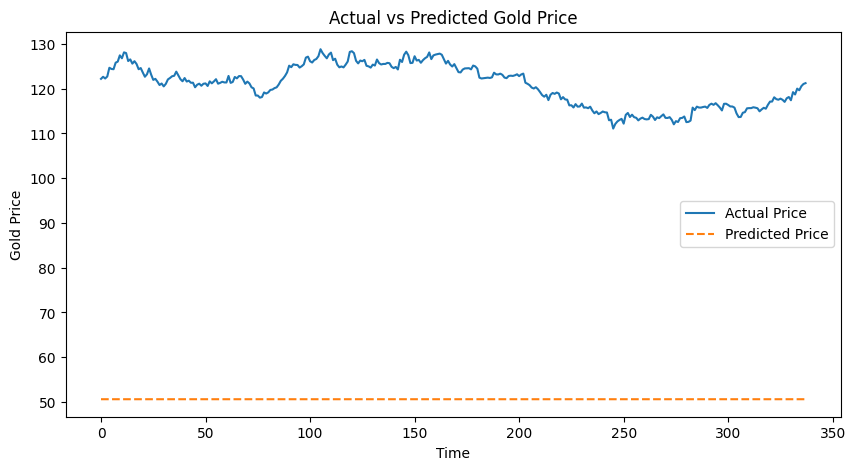

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from scikeras.wrappers import KerasRegressor

# Prepare the data
X = data[selected_features]
y = data['Close']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)

# Split the data into training and testing sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Define a function to create the LSTM model
def create_lstm_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Use KerasRegressor for compatibility with scikit-learn
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=20, batch_size=32, verbose=1,
                           units=50, dropout_rate=0.2)

# Define the grid search parameters (remove dropout_rate and units)
param_grid = {
    'optimizer': ['adam', 'rmsprop']
}

# Perform grid search
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and model
print("Best parameters found: ", grid_result.best_params_)

# Access the Keras model from the best estimator
best_model = grid_result.best_estimator_.model_

# Predict the prices
y_pred = best_model.predict(X_test)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Price')
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-13-40d3c42c5c4b>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1, 0] = pred[0]  # Update the last feature with the predicted price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━

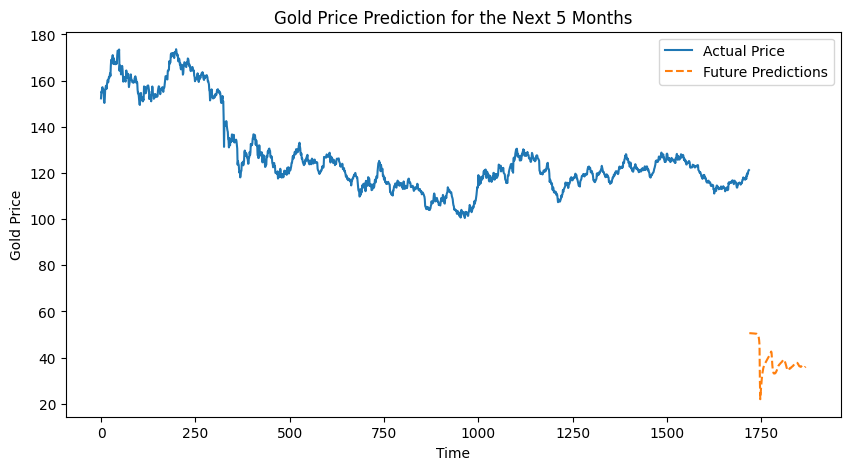

In [13]:
# Function to make predictions for the next n steps
def predict_future(model, X, n_steps):
    predictions = []
    current_input = X[-1]

    for _ in range(n_steps):
        pred = model.predict(current_input.reshape(1, time_steps, X.shape[2]))
        predictions.append(pred[0, 0])
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = pred[0]  # Update the last feature with the predicted price

    return predictions

# Predict the next 5 months (150 days)
future_predictions = predict_future(best_model, X_seq, 150)

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(range(len(y)), y, label='Actual Price')
plt.plot(range(len(y), len(y) + 150), future_predictions, label='Future Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction for the Next 5 Months')
plt.legend()
plt.show()


In [15]:
data.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,USO_Adj Close,USO_Volume,Day,Month,Year,DayOfWeek,DayOfYear,MA_5,MA_10,MA_20
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,234.339996,...,9.29,21598200,24,12,2018,0,358,118.712,118.135,117.2520
2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,246.179993,...,9.90,40978800,26,12,2018,2,360,119.014,118.347,117.4530
2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,248.070007,...,9.62,36578700,27,12,2018,3,361,119.642,118.625,117.7340
2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,247.750000,...,9.53,22803400,28,12,2018,4,362,120.006,118.978,118.0180
2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,249.559998,250.190002,247.470001,249.919998,...,9.66,28417400,31,12,2018,0,365,120.512,119.397,118.2935
